In [1]:
#! -*- coding: utf-8 -*-

# トランジェントのスペクトログラム

このチュートリアルでは、LIGOデータに見られるトランジェント（過渡現象）の例をいくつか示します。

以下、各トランジェントタイプの場合：

1. GPS時刻に対応するO1データセット内のデータファイルを検索する
 1. ヒント：https://losc.ligo.org/archive/O1/ を参照してください。
1. データファイルをダウンロードする
1. データファイルを読み、トランジェントの周りに200 msの白色化データのスペクトログラムをプロットします
1. スペクトログラムに表示される内容を説明する


ホワイトニングされたデータのスペクトログラムを作成する方法としては、
* gwpy（Qスキャン）の例：https://gwpy.github.io/docs/latest/examples/timeseries/qscan.html
* matplotlib（クイックビュー）を使用した例：http://beta.mybinder.org/repo/losc-tutorial/quickview
 * クイックビューコード(https://github.com/losc-tutorial/quickview)
* https://qscan.ligo.org を使用する（コードは不要）


### モジュールのインポートとセットアップ

In [2]:
# Standard python numerical analysis imports:
#!pip install gwpy
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json
import sys
import os

pyversion = sys.version_info.major
if pyversion == 2: 
    import urllib2
else:
    import urllib.request
    
import os
from gwpy.timeseries import TimeSeries

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

### データダウンロードのための便利な関数を定義する

In [3]:
try: os.mkdir('./data')
except: pass

# -- Handy function to download data file, and return the filename
def download(url):
    filename = os.path.join('data', url.split('/')[-1])
    if os.path.exists(filename):
        print('File ' + filename + " exists. Returning" )
        return filename
    print('Downloading ' + url )
    if pyversion == 2: 
        r = urllib2.urlopen(url).read()
        f = open(filename, 'w')   # write it to the right filename
        f.write(r)
        f.close()
    else:
        urllib.request.urlretrieve(url, filename)  
    print("File download complete")
    return filename

## ハードウェアインジェクション

LIGOデータには、ハードウェアインジェクションと呼ばれるシミュレートされた信号が含まれています。

1. O1の[ハードウェアインジェクションページ](https://losc.ligo.org/o1_inj/)を参照してください。
1. SNR> 30のCBCインジェクションを見つける
1. データファイルをダウンロードし、ホワイトニングされたデータのスペクトログラムを作成する

#### 課題：
* あなたがスペクトログラムで見たものを説明してください：
低周波ほど早く、高周波ほど遅く生じている

#### gwpyを使ってやってみましょう

In [4]:
## Make a spectrogram of a hardware injection
gps_inj = 1128668183
url_inj = 'https://losc.ligo.org/archive/data/O1/1128267776/H-H1_LOSC_4_V1-1128665088-4096.hdf5'
fn_inj = download(url_inj)

File data/H-H1_LOSC_4_V1-1128665088-4096.hdf5 exists. Returning


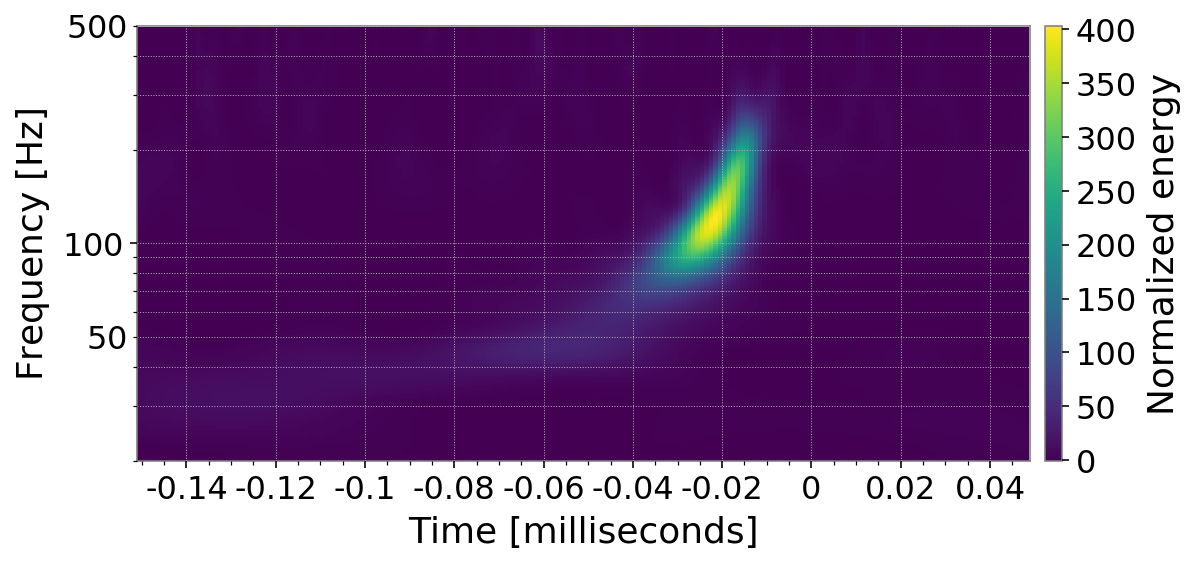

In [5]:
gps = gps_inj
fn = fn_inj
inj_data = TimeSeries.read(fn, format='hdf5.losc', start=gps-16, end=gps+16)
# -- Follow example at https://gwpy.github.io/docs/stable/examples/timeseries/qscan.html
plot = inj_data.q_transform().crop(gps-.15, gps+.05).plot(figsize=[8, 4])
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.set_xlabel('Time [milliseconds]')
ax.set_ylim(20, 500)
ax.grid(True, axis='y', which='both')
plot.add_colorbar(cmap='viridis', label='Normalized energy')

## Koi Fish(鯉)グリッチ

「グリッチ」は、データ内の機器によって作られたトランジェントです。グリッチは、それらの時間 - 周波数特性および/または原因によって分類出来ます。グリッチの1つのクラスは「鯉」として知られています

1. Koi Fish グリッチはHanfordデータでGPS時刻1132401286.330に発生した。
1. O1から対応するデータファイルを検索し、ダウンロードします。
1. このイベントの周りのホワイトニングデータのスペクトログラムを作成する

#### 質問：
* あなたがスペクトログラムで見たものを説明してください：
同時刻にいくつかの周波数で生じている

File download complete


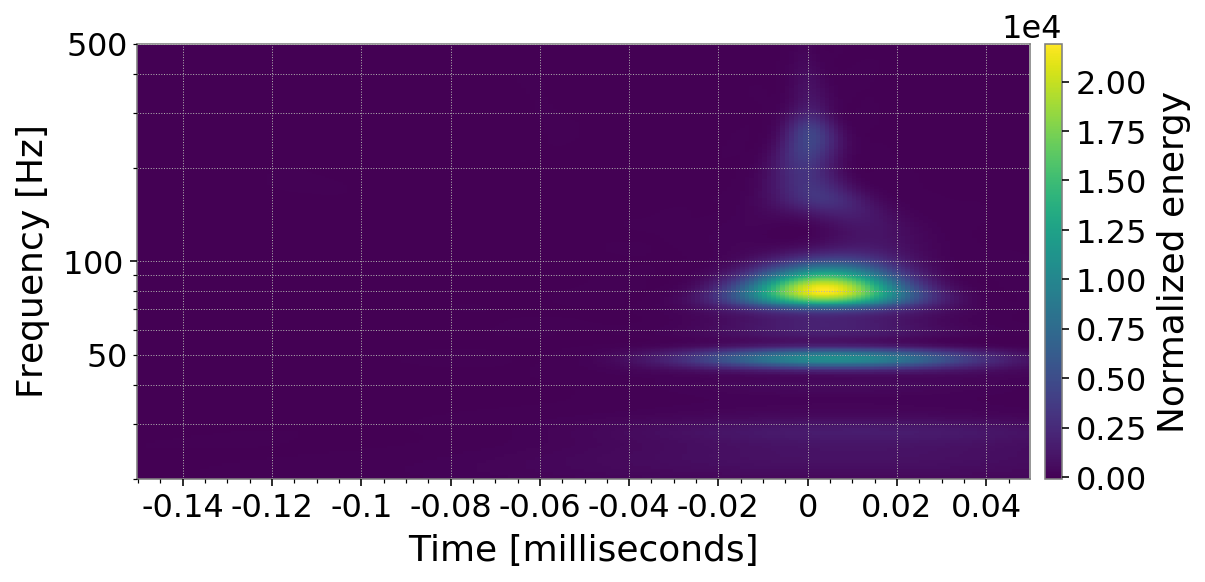

In [6]:
# -- Koi fish glitch
gps = 1132401286.330
url = 'https://losc.ligo.org/archive/data/O1/1131413504/H-H1_LOSC_4_V1-1132400640-4096.hdf5'
fn = download(url)

data = TimeSeries.read(fn, format='hdf5.losc', start=gps-16, end=gps+16)

# -- Follow example at https://gwpy.github.io/docs/stable/examples/timeseries/qscan.html
plot = data.q_transform().crop(gps-.15, gps+.05).plot(figsize=[8, 4])
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.set_xlabel('Time [milliseconds]')
ax.set_ylim(20, 500)
ax.grid(True, axis='y', which='both')
plot.add_colorbar(cmap='viridis', label='Normalized energy')

## スクラッチグリッチ

別のカテゴリの不具合は、「スクラッチグリッチ」として知られています。

1. ハンフォードのGPS時刻 1128779800.440のデータにスクラッチ・グリッチが発生した
2. 対応するデータファイルを見つけてダウンロードします。
3. この時期に白色化したデータのスペクトログラムをプロットする。

#### 質問：
* あなたがスペクトログラムで見たものを説明してください：
ランダムに見えるスペクトル


File download complete


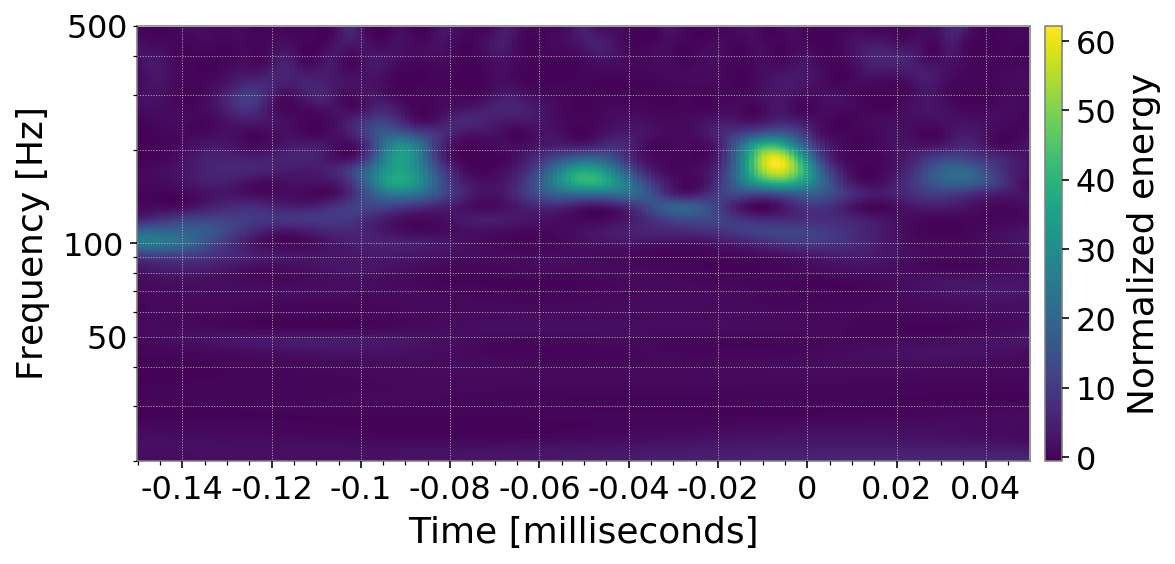

In [6]:
# -- Scratchy glitch
gps = 1128779800.440
url = 'https://losc.ligo.org/archive/data/O1/1128267776/H-H1_LOSC_4_V1-1128779776-4096.hdf5'
fn = download(url)

data = TimeSeries.read(fn, format='hdf5.losc', start=gps-16, end=gps+16)

# -- Follow example at https://gwpy.github.io/docs/stable/examples/timeseries/qscan.html
plot = data.q_transform().crop(gps-.15, gps+.05).plot(figsize=[8, 4])
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.set_xlabel('Time [milliseconds]')
ax.set_ylim(20, 500)
ax.grid(True, axis='y', which='both')
plot.add_colorbar(cmap='viridis', label='Normalized energy')

### もっと探求する

S6データセットには、超新星波形、宇宙線、白色雑音バースト、ブラックホールリングダウン、正弦波ガウス分布など、さまざまな形態のハードウェアインジェクションが含まれています。

ドキュメントについては、以下を参照してください。
https://losc.ligo.org/s6hwburst/

1. https://losc.ligo.org/s6hwburst/ の文書を使用して、これらの形態のそれぞれの時間を調べる。
2. 各モフォロジータイプの1つの大きな例のスペクトログラムを作成する
3. スペクトログラムの大きなピクセルにしきい値を設定してバースト信号を検索し、検出器間で一致する「トリガ」の時刻を探すアルゴリズムを書けるかどうかを確認します
4. いくつかのバーストハードウェアインジェクションでアルゴリズムをテストできます。比較のために、ハードウェアインジェクションなしでも試してみてください。
